# LST Sensitivity calculation using pyirf

This notebook allow to calculate the best LST sensitivity using real data.
It uses MC gammas to optimize the best gammaness and $\theta^2$ cuts.
The gammaness cut can be optimized based on gamma efficiency or on the best sensitivity.
Cuts are then applied to ON/OFF data to calculate sensitivity.
Sensitivity using MC gammas as signal is also calculated.
Some useful plots such as rates, cuts per energy bin, angular resolution, etc. are shown at the end. 


### Needed imports

In [1]:
from lstchain.io.io import read_dl2_to_pyirf, dl2_params_lstcam_key
import logging
import operator
from lstchain.mc import plot_utils

import numpy as np
from astropy import table
import astropy.units as u
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.table import QTable
import pandas as pd

from pyirf.io.eventdisplay import read_eventdisplay_fits
from pyirf.binning import (
    create_bins_per_decade,
    add_overflow_bins,
    create_histogram_table,
)
from pyirf.cuts import calculate_percentile_cut, evaluate_binned_cut
from pyirf.sensitivity import calculate_sensitivity
from pyirf.utils import calculate_theta, calculate_source_fov_offset
from pyirf.benchmarks import energy_bias_resolution, angular_resolution

from pyirf.cuts import calculate_percentile_cut, evaluate_binned_cut
from pyirf.sensitivity import calculate_sensitivity, estimate_background
from pyirf.utils import calculate_theta, calculate_source_fov_offset
from pyirf.benchmarks import energy_bias_resolution, angular_resolution

from pyirf.spectral import (
    calculate_event_weights,
    PowerLaw,
    CRAB_HEGRA,
    IRFDOC_PROTON_SPECTRUM
)
from pyirf.cut_optimization import optimize_gh_cut

from pyirf.irf import (
    effective_area_per_energy,
    energy_dispersion,
    psf_table,
    background_2d,
)

from pyirf.io import (
    create_aeff2d_hdu,
    create_psf_table_hdu,
    create_energy_dispersion_hdu,
    create_rad_max_hdu,
    create_background_2d_hdu,
)

log = logging.getLogger("pyirf")

/home/queenmab/anaconda3/envs/lst-dev/lib/python3.7/site-packages/ctapipe/tools/stage1.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Initial variables

In [2]:
#Observation time for sensitivity
T_OBS = 50 * u.hour
# scaling between on and off region.
# Make off region 5 times larger than on region for better
# background statistics
ALPHA = 1/5

# Radius to use for calculating bg rate
MAX_BG_RADIUS = 1.0 * u.deg

# gamma efficiency used for first calculation of the binned theta cuts
# initial theta cuts are calculated using a fixed g/h cut corresponding to this efficiency
# then g/h cuts are optimized after applying these initial theta cuts. 
INITIAL_GH_CUT_EFFICENCY = 0.5

#gamma efficiency used for gh cuts calculation
MAX_GH_CUT_EFFICIENCY = 0.8
GH_CUT_EFFICIENCY_STEP = 0.01

#Number of energy bins
N_EBINS = 20
#Energy range
EMIN=0.05  #TeV
EMAX=50  #TeV

#Fixed cuts
INTENSITY_CUT = 100
LEAKAGE2_CUT = 0.2

In [3]:
def get_obstime_real(events):
    """Calculate the effective observation time"""
    deltat = np.diff(events.dragon_time)
    rate=1/np.mean(deltat[(deltat > 0) & (deltat < 0.1)])
    dead_time = np.amin(deltat)
    t_elapsed = events.shape[0]/rate * u.s
    total_dead_time=events.shape[0]*dead_time
    t_eff = t_elapsed/(1+rate*dead_time)
    print("ELAPSED TIME: %.2f s\n" % t_elapsed.to_value(),
          "EFFECTIVE TIME: %.2f s\n" % t_eff.to_value(),
          "DEAD TIME: %0.2E s\n" % dead_time,
          "TOTAL DEAD TIME: %.2f s\n" % total_dead_time, 
          "RATE: %.2f 1/s\n" % rate
    )

    return t_eff

In [4]:
def read_real_dl2_to_pyirf(filename):
    """
    Read DL2 files of real data from lstchain and convert into pyirf internal format
    Parameters
    ----------
    filename: path
    Returns
    -------
    `astropy.table.QTable`, `pyirf.simulations.SimulatedEventsInfo`
    """

    ## mapping
    name_mapping = {
        'alt_tel': 'pointing_alt',
        'az_tel': 'pointing_az',
        'gammaness': 'gh_score',
    }

    unit_mapping = {
        'reco_energy': u.TeV,
        'pointing_alt': u.rad,
        'pointing_az': u.rad,
        'reco_alt': u.rad,
        'reco_az': u.rad,
    }

    events = pd.read_hdf(filename, key=dl2_params_lstcam_key).rename(columns=name_mapping)
    
    obstime_real = get_obstime_real(events) #Calculate effective observation time
    
    events = events
    events = table.QTable.from_pandas(events)

    for k, v in unit_mapping.items():
        events[k] *= v

    return events, obstime_real

### Read hdf5 files into pyirf format

In [5]:
file_gammas= "/home/queenmab/DATA/LST/dl2_gamma_20deg_180deg_off0.0deg_20201023_v0.6.3_prod5_local_wo_n_islands_testing.h5"
#file_gammas_prod3_61="/home/queenmab/DATA/LST/dl2_gamma_south_pointing_20201005_v0.6.1_local_DL1_testing.h5"
#file_gammas_prod3_63="/home/queenmab/DATA/LST/dl2_gamma_south_pointing_20201017_v0.6.3_prod3_local_DL1_testing.h5"
file_protons="/home/queenmab/DATA/LST/dl2_proton_20deg_180deg_20201023_v0.6.3_prod5_local_wo_n_islands_testing.h5"
#file_protons_prod3_63="/home/queenmab/DATA/LST/dl2_proton_south_pointing_20201017_v0.6.3_prod3_local_DL1_testing.h5"
#file_protons_prod3_61="/home/queenmab/DATA/LST/dl2_proton_south_pointing_20201005_v0.6.1_local_DL1_testing.h5"
file_on = "/home/queenmab/DATA/LST/ON/Run2007_on.h5"
file_off = "/home/queenmab/DATA/LST/OFF.h5"

In [6]:
events_g, simu_info_g = read_dl2_to_pyirf(file_gammas)
events_p, simu_info_p = read_dl2_to_pyirf(file_protons)
events_off, obstime_off = read_real_dl2_to_pyirf(file_off)
events_on, obstime_on = read_real_dl2_to_pyirf(file_on)

Table '/simulation/run_config' has column 'obs_id' that is not in container MCHeaderContainer. It will be skipped
Table '/simulation/run_config' has column 'obs_id' that is not in container MCHeaderContainer. It will be skipped


ELAPSED TIME: 1290.88 s
 EFFECTIVE TIME: 1228.98 s
 DEAD TIME: 7.63E-06 s
 TOTAL DEAD TIME: 65.02 s
 RATE: 6601.60 1/s

ELAPSED TIME: 1223.88 s
 EFFECTIVE TIME: 1154.36 s
 DEAD TIME: 7.63E-06 s
 TOTAL DEAD TIME: 73.71 s
 RATE: 7893.55 1/s



### Apply quality cuts

In [7]:
for events in (events_g, events_p, events_on, events_off):
        events['good_events'] = (events['intensity']>=INTENSITY_CUT) & \
        (events['leakage_intensity_width_2']<=LEAKAGE2_CUT)

In [8]:
particles = {
         "gamma": {
                "events": events_g[events_g['good_events']],
                "simulation_info": simu_info_g,
                "target_spectrum": CRAB_HEGRA
            },
        "proton": {
                "events": events_p[events_p['good_events']],
                "simulation_info": simu_info_p,
                "target_spectrum": IRFDOC_PROTON_SPECTRUM
            },
        "off": {
                "events": events_off[events_off['good_events']]
            },
        "on":{
                "events": events_on[events_on['good_events']]
            }
        }

In [9]:
# Manage MC gammas:
#Get simulated spectrum
particles["gamma"]["simulated_spectrum"] = PowerLaw.from_simulation(particles["gamma"]["simulation_info"], 
                                                                    T_OBS)
#Reweight to target spectrum (Crab Hegra)
particles["gamma"]["events"]["weight"] = calculate_event_weights(
        particles["gamma"]["events"]["true_energy"], 
        particles["gamma"]["target_spectrum"], 
        particles["gamma"]["simulated_spectrum"]
        )
for prefix in ('true', 'reco'):
    k = f"{prefix}_source_fov_offset"
    particles["gamma"]["events"][k] = calculate_source_fov_offset(particles["gamma"]["events"], prefix=prefix) 
particles["gamma"]["events"]["source_fov_offset"] = calculate_source_fov_offset(particles["gamma"]["events"])
# calculate theta / distance between reco and assumed source position
# we handle only ON observations here, so the assumed source position
# is the pointing position
particles["gamma"]["events"]["theta"] = calculate_theta(
        particles["gamma"]["events"],
        assumed_source_az=particles["gamma"]["events"]["true_az"],
        assumed_source_alt=particles["gamma"]["events"]["true_alt"],
        )

In [10]:
# Manage MC protons:
#Get simulated spectrum
particles["proton"]["simulated_spectrum"] = PowerLaw.from_simulation(particles["proton"]["simulation_info"], 
                                                                    T_OBS)
#Reweight to target spectrum:
particles["proton"]["events"]["weight"] = calculate_event_weights(
        particles["proton"]["events"]["true_energy"], 
        particles["proton"]["target_spectrum"], 
        particles["proton"]["simulated_spectrum"]
        )
for prefix in ('true', 'reco'):
    k = f"{prefix}_source_fov_offset"
    particles["proton"]["events"][k] = calculate_source_fov_offset(particles["proton"]["events"], prefix=prefix)        
# calculate theta / distance between reco and assumed source position
# we handle only ON observations here, so the assumed source position
# is the pointing position
particles["proton"]["events"]["theta"] = calculate_theta(
        particles["proton"]["events"],
        assumed_source_az=particles["proton"]["events"]["pointing_az"],
        assumed_source_alt=particles["proton"]["events"]["pointing_alt"],
        )

In [11]:
#Manage real data: OFF

#Weight by the actual observation time
particles["off"]["events"]["weight"] = T_OBS.to(u.s)/obstime_off

#True az and true alt are unknown for real data, pointing is used instead
particles["off"]["events"]["true_az"] = particles["off"]["events"]["pointing_az"]
particles["off"]["events"]["true_alt"] = particles["off"]["events"]["pointing_alt"]

for prefix in ('true', 'reco'):
    k = f"{prefix}_source_fov_offset"
    particles["off"]["events"][k] = calculate_source_fov_offset(particles["off"]["events"], prefix=prefix)
# calculate theta / distance between reco and assumed source position
# we handle only ON observations here, so the assumed source position
# is the pointing position
particles["off"]["events"]["theta"] = calculate_theta(
        particles["off"]["events"],
        assumed_source_az=particles["off"]["events"]["pointing_az"],
        assumed_source_alt=particles["off"]["events"]["pointing_alt"],
    )


In [12]:
#Manage real data: ON  

#Weight by the actual observation time
particles["on"]["events"]["weight"] = T_OBS.to(u.s)/obstime_on

#True az and true alt are unknown for real data, pointing is used instead
particles["on"]["events"]["true_az"] = particles["on"]["events"]["pointing_az"]
particles["on"]["events"]["true_alt"] = particles["on"]["events"]["pointing_alt"]

for prefix in ('true', 'reco'):
    k = f"{prefix}_source_fov_offset"
    particles["on"]["events"][k] = calculate_source_fov_offset(particles["on"]["events"], prefix=prefix)

particles["on"]["events"]["theta"] = calculate_theta(
        particles["on"]["events"],
        assumed_source_az=particles["on"]["events"]["pointing_az"],
        assumed_source_alt=particles["on"]["events"]["pointing_alt"],
    )

In [13]:
#Get events
gammas = particles["gamma"]["events"]
protons = particles["proton"]["events"]
on = particles["on"]["events"]
off = particles["off"]["events"]

## Calculate the best cuts for sensitivity

### Define bins

In [14]:
#Sensitivity energy bins
sensitivity_bins = np.logspace(np.log10(EMIN),
    np.log10(EMAX), N_EBINS + 1) * u.TeV

### Data to optimize best cuts

In [43]:
signal=gammas
background=protons

In [44]:
#Calculate an initial GH cut for calculating initial theta cuts, based on INITIAL_GH_CUT_EFFICIENCY
INITIAL_GH_CUT = np.quantile(signal['gh_score'], (1 - INITIAL_GH_CUT_EFFICENCY))
INITIAL_GH_CUT

0.36557142857142855

### Initial $\theta$ cut

In [45]:
# theta cut is 68 percent containmente of the gammas
# for now with a fixed global, unoptimized score cut
mask_theta_cuts = signal["gh_score"] >= INITIAL_GH_CUT
theta_cuts = calculate_percentile_cut(
        signal["theta"][mask_theta_cuts],
        signal["reco_energy"][mask_theta_cuts],
        bins=sensitivity_bins,
        fill_value=np.nan * u.deg,
        percentile=68,
)


In [46]:
# evaluate the initial theta cut
signal["selected_theta"] = evaluate_binned_cut(
    signal["theta"], signal["reco_energy"], theta_cuts, operator.le
    )

### Run block below for G/H cut optimization based on best sensitivity

In [47]:
log.info("Optimizing G/H separation cut for best sensitivity")
gh_cut_efficiencies = np.arange(
        GH_CUT_EFFICIENCY_STEP,
        MAX_GH_CUT_EFFICIENCY + GH_CUT_EFFICIENCY_STEP / 2,
        GH_CUT_EFFICIENCY_STEP
)
sensitivity_step_2, gh_cuts = optimize_gh_cut(
    signal[signal["selected_theta"]],
    background,
    reco_energy_bins=sensitivity_bins,
    gh_cut_efficiencies=gh_cut_efficiencies,
    theta_cuts=theta_cuts,
    op=operator.ge,
    alpha=ALPHA,
    background_radius=MAX_BG_RADIUS,
)

100%|██████████| 80/80 [00:28<00:00,  2.77it/s]


In [48]:
#Evaluate gh cut
for tab in (gammas, protons, on, off):
    tab["selected_gh"] = evaluate_binned_cut(
    tab["gh_score"], tab["reco_energy"], gh_cuts, operator.ge
    )

### Setting of $\theta$ cut as 68% containment of events surviving the cuts

In [49]:
#Evaluate gh cut:
for tab in (gammas, protons, on, off):
    tab["selected_gh"] = evaluate_binned_cut(
    tab["gh_score"], tab["reco_energy"], gh_cuts, operator.ge
    )

theta_cuts_opt = calculate_percentile_cut(
    gammas[gammas["selected_gh"]]["theta"],
    gammas[gammas["selected_gh"]]["reco_energy"],
    sensitivity_bins,
    percentile=68,
    fill_value=0.32 * u.deg,
    )

### Evaluate optimized cuts

In [50]:
gammas["selected_theta"] = evaluate_binned_cut(
        gammas["theta"], gammas["reco_energy"], theta_cuts_opt, operator.le
    )
gammas["selected"] = gammas["selected_theta"] & gammas["selected_gh"]

protons["selected"] =  protons["selected_gh"]

on["selected_theta"] = evaluate_binned_cut(
        on["theta"], on["reco_energy"], theta_cuts_opt, operator.le
    )
on["selected"] = on["selected_theta"] & on["selected_gh"]

off["selected"] = off["selected_gh"]

### Crate event histograms

In [51]:
gamma_hist = create_histogram_table(
    gammas[gammas["selected"]], bins=sensitivity_bins
    )    
proton_hist = estimate_background(
    protons[protons["selected"]],
    reco_energy_bins=sensitivity_bins,
    theta_cuts=theta_cuts_opt,
    alpha=ALPHA,
    background_radius=MAX_BG_RADIUS,
    )
on_hist = create_histogram_table(
    on[on["selected"]], bins=sensitivity_bins
    )
off_hist = estimate_background(
    off[off["selected"]],
    reco_energy_bins=sensitivity_bins,
    theta_cuts=theta_cuts_opt,
    alpha=ALPHA,
    background_radius=MAX_BG_RADIUS,
    )

### Sensitivity with MC gammas and protons

In [52]:
sensitivity_mc = calculate_sensitivity(
    gamma_hist, proton_hist, alpha=ALPHA
)
sensitivity_mc

Could not calculate relative significance for n_signal=0.0, n_off=0.0, returning nan f(a) and f(b) must have different signs


reco_energy_low,reco_energy_high,reco_energy_center,n_signal,n_signal_weighted,n_background,n_background_weighted,significance,relative_sensitivity
TeV,TeV,TeV,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64
0.049999999999999996,0.0706268772311377,0.06031343861556884,197.44143988956955,451.8093909844591,29.741490393464176,33150.559959700215,4.999999999999114,0.1867941720809551
0.0706268772311377,0.09976311574844397,0.08519499648979084,283.18458162561103,521.7591562376701,45.24804415681342,44364.701986461674,4.9999999999980105,0.0653553153994025
0.09976311574844397,0.14091914656322266,0.12034113115583331,314.4156000591004,475.1554936799429,42.29372737588742,36712.003519601225,5.0000000000005,0.03897552994410567
0.14091914656322266,0.1990535852767486,0.16998636591998562,8.65325508860953,10.000000000000002,0.0,0.0,5.986250026900072,0.030794502094695836
0.1990535852767486,0.2811706625951745,0.24011212393596154,251.98513774548647,250.96560875756865,15.8241195215565,10016.38392686615,5.000000000000119,0.018513344922892253
0.2811706625951745,0.39716411736214063,0.3391673899786576,225.8132443636066,180.90961523105855,9.16586604394642,5109.994335267751,5.000000000000301,0.017910314432392656
0.39716411736214063,0.5610092271509817,0.47908667225656115,212.08661422930325,137.05557757565546,6.176545071624134,2871.2171052913354,5.000000000002797,0.02101948604849388
0.5610092271509817,0.7924465962305566,0.6767279116907692,110.58079886441136,57.419495057136345,1.1451160467385122,444.64686543125424,4.999999999999998,0.018256694545882676


### Sensitivity with MC gammas with real off

In [53]:
sensitivity_mcoff = calculate_sensitivity(
    gamma_hist, off_hist, alpha=ALPHA
)
sensitivity_mcoff

Could not calculate relative significance for n_signal=0.0, n_off=0.0, returning nan f(a) and f(b) must have different signs


reco_energy_low,reco_energy_high,reco_energy_center,n_signal,n_signal_weighted,n_background,n_background_weighted,significance,relative_sensitivity
TeV,TeV,TeV,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64
0.049999999999999996,0.0706268772311377,0.06031343861556884,241.87898312405616,553.4967538645534,341.3190088011841,49990.66578987288,4.999999999999124,0.22883536719399827
0.0706268772311377,0.09976311574844397,0.08519499648979084,387.5906671401456,714.124258784676,487.5793917084662,71412.4258784676,5.402867909335898,0.08945088094626025
0.09976311574844397,0.14091914656322266,0.12034113115583331,314.3379701875084,475.0381767912335,250.53159341411094,36693.65266282609,4.999999999999682,0.038965906803955425
0.14091914656322266,0.1990535852767486,0.16998636591998562,30.22859265930299,34.93320415238141,0.9698376525260735,142.04550203095963,5.000000000000003,0.10757506284449463
0.1990535852767486,0.2811706625951745,0.24011212393596154,260.06083704056414,259.00863386557836,72.94919099437546,10684.370142321159,5.000000000000108,0.01910666644923695
0.2811706625951745,0.39716411736214063,0.3391673899786576,211.50178323230932,169.4440303228134,30.470311443389452,4462.7785637551215,5.000000000000614,0.016775204888349406
0.39716411736214063,0.5610092271509817,0.47908667225656115,173.6971653082109,112.24737308896007,12.894892342513543,1888.6268765258835,5.000000000011082,0.01721478347950554
0.5610092271509817,0.7924465962305566,0.6767279116907692,103.46389267314201,53.72401479231425,2.617408106830885,383.3539021570431,4.999999999999993,0.017081705906082552


### Sensitivity with ON data

In [54]:
on_hist

reco_energy_low,reco_energy_high,reco_energy_center,n,n_weighted
TeV,TeV,TeV,,
float64,float64,float64,int64,float64
0.049999999999999996,0.0706268772311377,0.06031343861556884,82,12786.284555632477
0.0706268772311377,0.09976311574844397,0.08519499648979084,134,20894.66012749714
0.09976311574844397,0.14091914656322266,0.12034113115583331,70,10915.120962125147
0.14091914656322266,0.1990535852767486,0.16998636591998562,0,0.0
0.1990535852767486,0.2811706625951745,0.24011212393596154,34,5301.630181603643
0.2811706625951745,0.39716411736214063,0.3391673899786576,22,3430.466588096475
0.39716411736214063,0.5610092271509817,0.47908667225656115,14,2183.0241924250295
0.5610092271509817,0.7924465962305566,0.6767279116907692,9,1403.372695130376


In [59]:
#Signal = ON - ALPHA*OFF
import copy
excess_hist=copy.copy(on_hist)
excess_hist["n_weighted"] = on_hist["n_weighted"] - ALPHA*off_hist["n_weighted"]
excess_hist["n"] = on_hist["n"] - ALPHA*off_hist["n"]

sensitivity_on = calculate_sensitivity(
    excess_hist, off_hist, alpha=ALPHA
    )
sensitivity_on

/home/queenmab/GitHub/pyirf/pyirf/sensitivity.py:253: RuntimeWarning: invalid value encountered in multiply
  s["n_signal"] = signal_hist["n"] * rel_sens
/home/queenmab/anaconda3/envs/lst-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


reco_energy_low,reco_energy_high,reco_energy_center,n_signal,n_signal_weighted,n_background,n_background_weighted,significance,relative_sensitivity
TeV,TeV,TeV,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64
0.049999999999999996,0.0706268772311377,0.06031343861556884,2.7268752846547413,553.496753864553,341.3190088011841,49990.66578987288,5.000000000001341,0.19851746728298209
0.0706268772311377,0.09976311574844397,0.08519499648979084,3.940336806959623,714.1242587846762,487.5793917084662,71412.4258784676,5.402867909335898,0.10800141617394483
0.09976311574844397,0.14091914656322266,0.12034113115583331,2.6424011272563472,475.0381767912333,250.53159341411094,36693.65266282609,4.999999999999682,0.13282615143606855
0.14091914656322266,0.1990535852767486,0.16998636591998562,-inf,-inf,0.9698376525260735,142.04550203095963,0.0,inf
0.1990535852767486,0.2811706625951745,0.24011212393596154,1.588558248392079,259.0086338655784,72.94919099437546,10684.370142321159,5.000000000000108,0.08184157683322428
0.2811706625951745,0.39716411736214063,0.3391673899786576,1.061962505481275,169.4440303228125,30.470311443389452,4462.7785637551215,5.0000000000005285,0.06676516183798158
0.39716411736214063,0.5610092271509817,0.47908667225656115,0.7101204812997518,112.24737308896003,12.894892342513543,1888.6268765258835,5.000000000011059,0.062176616981358165
0.5610092271509817,0.7924465962305566,0.6767279116907692,0.34325163302743683,53.72401479231432,2.617408106830885,383.3539021570431,5.000000000000002,0.040494412646192995


### Plot Sensitivity curves

In [60]:
# scale relative sensitivity by Crab flux to get the flux sensitivity
spectrum = particles['gamma']['target_spectrum']
for s in (sensitivity_mc, sensitivity_mcoff, sensitivity_on):
    s["flux_sensitivity"] = (
        s["relative_sensitivity"] * spectrum(s["reco_energy_center"])
     )

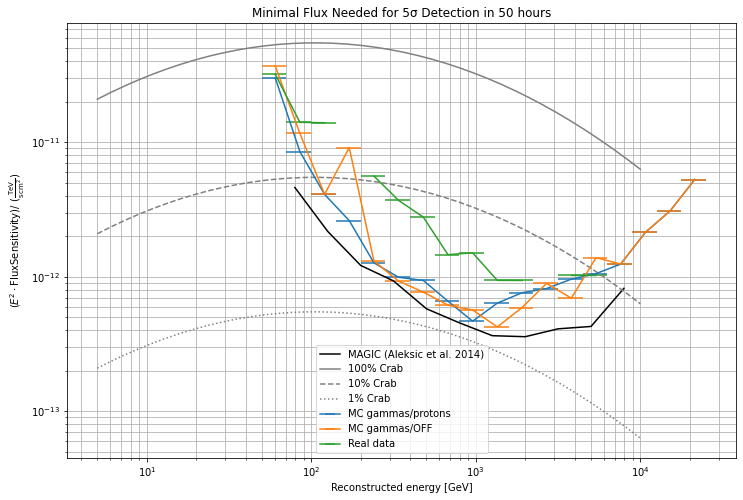

In [61]:
plt.figure(figsize=(12,8))
ax=plt.axes()
unit = u.Unit('TeV cm-2 s-1')

e = sensitivity_mc['reco_energy_center']

s_mc = (e**2 * sensitivity_mc['flux_sensitivity'])

plt.errorbar(
    e.to_value(u.GeV),
    s_mc.to_value(unit),
    xerr=(sensitivity_mc['reco_energy_high'] - sensitivity_mc['reco_energy_low']).to_value(u.GeV) / 2,
    label='MC gammas/protons',
    )

s_mcoff = (e**2 * sensitivity_mcoff['flux_sensitivity'])

plt.errorbar(
    e.to_value(u.GeV),
    s_mcoff.to_value(unit),
    xerr=(sensitivity_mcoff['reco_energy_high'] - sensitivity_mcoff['reco_energy_low']).to_value(u.GeV) / 2,
    label='MC gammas/OFF',
    )


s_on = (e**2 * sensitivity_on['flux_sensitivity'])

plt.errorbar(
    e.to_value(u.GeV),
    s_on.to_value(unit),
    xerr=(sensitivity_on['reco_energy_high'] - sensitivity_on['reco_energy_low']).to_value(u.GeV) / 2,
    label='Real data',
    )

#Plot magic sensitivity
s = np.loadtxt('../lstchain/spectra/data/magic_sensitivity.txt', skiprows = 1)
ax.loglog(s[:,0], s[:,3] * np.power(s[:,0]/ 1e3, 2),
              color = 'black', label = 'MAGIC (Aleksic et al. 2014)')

#Plot Crab SED
plot_utils.plot_Crab_SED(ax, 100, 5*u.GeV, 1e4*u.GeV, label="100% Crab") #Energy in GeV
plot_utils.plot_Crab_SED(ax, 10, 5*u.GeV, 1e4*u.GeV, linestyle='--', label="10% Crab") #Energy in GeV
plot_utils.plot_Crab_SED(ax, 1, 5*u.GeV, 1e4*u.GeV, linestyle=':', label="1% Crab") #Energy in GeV


# Style settings
plt.title('Minimal Flux Needed for 5σ Detection in 50 hours')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Reconstructed energy [GeV]")
plt.ylabel(rf"$(E^2 \cdot \mathrm{{Flux Sensitivity}}) /$ ({unit.to_string('latex')})")
plt.grid(which="both")
plt.legend()
plt.show()

### Rates

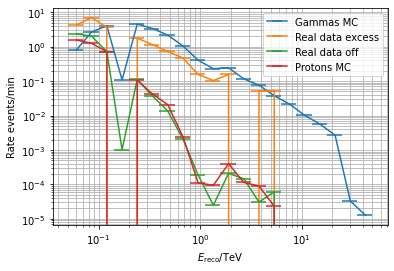

In [58]:
rate_gammas = gamma_hist["n_weighted"]/T_OBS.to(u.min)
rate_on = on_hist["n_weighted"]/T_OBS.to(u.min)
area_ratio_p = (1-np.cos(theta_cuts_opt['cut']))/(1-np.cos(MAX_BG_RADIUS))
rate_off = off_hist["n_weighted"]*area_ratio_p/T_OBS.to(u.min)
rate_proton = proton_hist["n_weighted"]*area_ratio_p/T_OBS.to(u.min)

plt.errorbar(
    0.5 * (gamma_hist['reco_energy_low'] + gamma_hist['reco_energy_high']).to_value(u.TeV),
    rate_gammas.to_value(1/u.min),
    xerr=0.5 * (gamma_hist['reco_energy_high'] - gamma_hist['reco_energy_low']).to_value(u.TeV),
    label='Gammas MC',
)
plt.errorbar(
    0.5 * (on_hist['reco_energy_low'] + on_hist['reco_energy_high']).to_value(u.TeV),
    rate_on.to_value(1/u.min),
    xerr=0.5 * (on_hist['reco_energy_high'] - on_hist['reco_energy_low']).to_value(u.TeV),
    label='Real data excess',
)
plt.errorbar(
    0.5 * (off_hist['reco_energy_low'] + off_hist['reco_energy_high']).to_value(u.TeV),
    rate_off.to_value(1/u.min),
    xerr=0.5 * (off_hist['reco_energy_high'] - off_hist['reco_energy_low']).to_value(u.TeV),
    label='Real data off',
)
plt.errorbar(
    0.5 * (proton_hist['reco_energy_low'] + proton_hist['reco_energy_high']).to_value(u.TeV),
    rate_proton.to_value(1/u.min),
    xerr=0.5 * (proton_hist['reco_energy_high'] - proton_hist['reco_energy_low']).to_value(u.TeV),
    label='Protons MC',
)
plt.legend()
plt.ylabel('Rate events/min')
plt.xlabel(r'$E_\mathrm{reco} / \mathrm{TeV}$')
plt.xscale('log')
plt.yscale('log')
plt.grid(which="both")
plt.show()

### Cuts

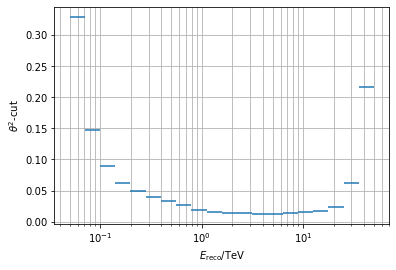

In [31]:
plt.errorbar(
    0.5 * (theta_cuts['low'] + theta_cuts['high']).to_value(u.TeV),
    (theta_cuts['cut']**2).to_value(u.deg**2),
    xerr=0.5 * (theta_cuts['high'] - theta_cuts['low']).to_value(u.TeV),
    ls='',
    )
plt.ylabel(r'$\theta^2$-cut')
plt.xlabel(r'$E_\mathrm{reco} / \mathrm{TeV}$')
plt.xscale('log')
plt.grid(which="both")
plt.show()

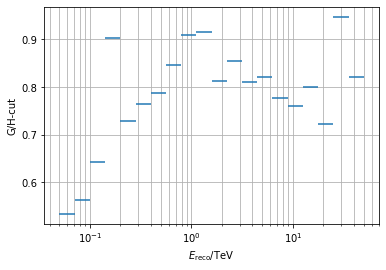

In [32]:
plt.errorbar(
    0.5 * (gh_cuts['low'] + gh_cuts['high']).to_value(u.TeV),
    gh_cuts['cut'],
    xerr=0.5 * (gh_cuts['high'] - gh_cuts['low']).to_value(u.TeV),
    ls='',
    )
plt.ylabel('G/H-cut')
plt.xlabel(r'$E_\mathrm{reco} / \mathrm{TeV}$')
plt.xscale('log')
plt.grid(which="both")
plt.show()

### Angular Resolution

In [33]:
selected_events_gh = table.vstack(
        gammas[gammas["selected_gh"]], protons[protons["selected_gh"]])

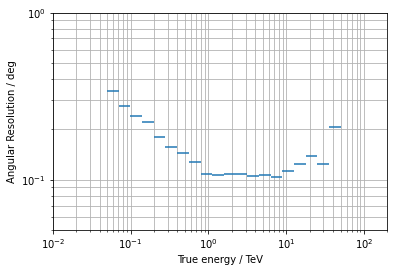

In [34]:
ang_res = angular_resolution(selected_events_gh[selected_events_gh["selected_gh"]], sensitivity_bins,)
plt.errorbar(
    0.5 * (ang_res['true_energy_low'] + ang_res['true_energy_high']),
    ang_res['angular_resolution'],
    xerr=0.5 * (ang_res['true_energy_high'] - ang_res['true_energy_low']),
    ls=''
    )

# Style settings
plt.xlim(1.e-2, 2.e2)
plt.ylim(0.5e-1, 1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy / TeV")
plt.ylabel("Angular Resolution / deg")
plt.grid(which="both")
plt.show()

### Energy resolution

In [35]:
selected_events = table.vstack(
        gammas[gammas["selected"]], protons[protons["selected"]])

No handles with labels found to put in legend.


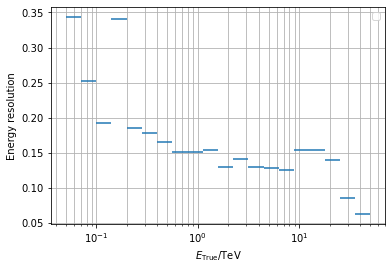

In [36]:
selected_events = table.vstack(
        gammas[gammas["selected"]], protons[protons["selected"]])

bias_resolution = energy_bias_resolution(
    selected_events, sensitivity_bins,
        )

# Plot function
plt.errorbar(
    0.5 * (bias_resolution['true_energy_low'] + bias_resolution['true_energy_high']),
    bias_resolution['resolution'],
    xerr=0.5 * (bias_resolution['true_energy_high'] - bias_resolution['true_energy_low']),
    ls=''
    )
plt.xscale('log')

# Style settings
plt.xlabel(r"$E_\mathrm{True} / \mathrm{TeV}$")
plt.ylabel("Energy resolution")
plt.grid(which="both")
plt.legend(loc="best")
plt.show()

### Reco Alt/Az for MC selected events

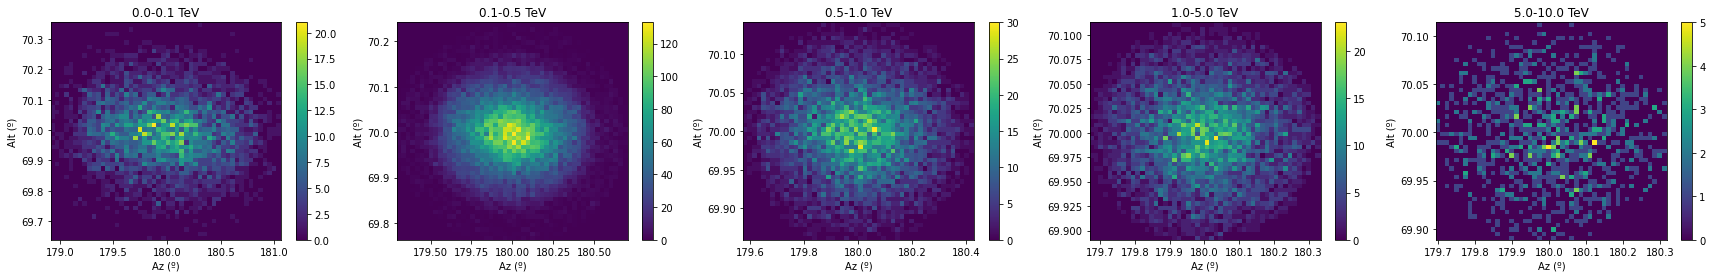

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,4))
emin_bins=[0.0, 0.1,0.5, 1, 5] * u.TeV
emax_bins=[0.1,0.5,1,5,10] * u.TeV

for i, ax in enumerate(axs):
    events=selected_events[(selected_events['reco_energy']>emin_bins[i]) & \
                                    (selected_events['reco_energy']<emax_bins[i]) ]
    pcm = ax.hist2d(events['reco_az'].to_value(u.deg), events['reco_alt'].to_value(u.deg), bins=50)
    ax.title.set_text("%.1f-%.1f TeV" % (emin_bins[i].to_value(), emax_bins[i].to_value()))
    ax.set_xlabel("Az (º)")
    ax.set_ylabel("Alt (º)")
    fig.colorbar(pcm[3], ax=ax)
plt.show()

### Reco camera coordinates for real on events

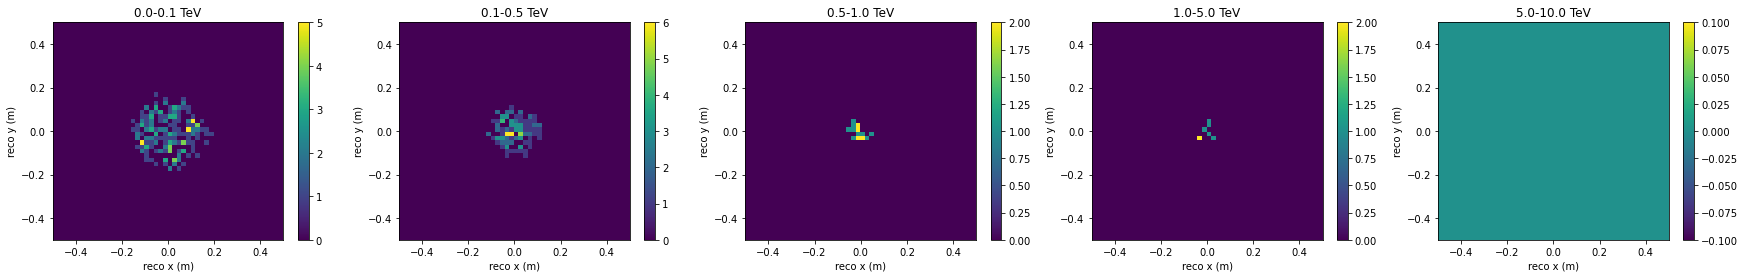

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,4))
emin_bins=[0.0, 0.1,0.5, 1, 5] * u.TeV
emax_bins=[0.1,0.5,1,5,10] * u.TeV
selected_events_real=on[on["selected"]]
for i, ax in enumerate(axs):
    events=selected_events_real[(selected_events_real['reco_energy']>emin_bins[i]) & \
                                    (selected_events_real['reco_energy']<emax_bins[i]) ]
    #pcm = ax.hist2d(events['reco_az'].to_value(u.deg), events['reco_alt'].to_value(u.deg), bins=50)
    pcm = ax.hist2d(events['reco_src_x'], events['reco_src_y'], range=[(-0.5,0.5),(-0.5,0.5)],bins=50)
    ax.title.set_text("%.1f-%.1f TeV" % (emin_bins[i].to_value(), emax_bins[i].to_value()))
    ax.set_xlabel("reco x (m)")
    ax.set_ylabel("reco y (m)") 
    fig.colorbar(pcm[3], ax=ax)
plt.show()

### Checks on number of islands

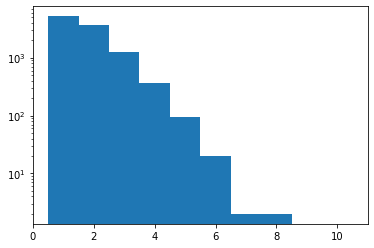

In [62]:
gammas_selected=gammas[(gammas['selected']) & (gammas['reco_energy']>1.*u.TeV)]
plt.hist(gammas_selected['n_islands'], bins=10, range=(0.5, 10.5))
plt.yscale('log')

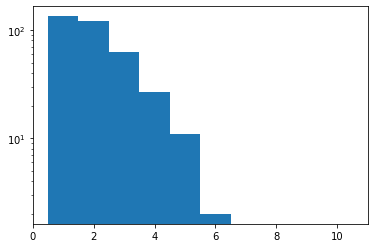

In [63]:
protons_selected=protons[(protons['selected']) & (protons['reco_energy']>1.*u.TeV)]
plt.hist(protons_selected['n_islands'], bins=10, range=(0.5, 10.5))
plt.yscale('log')